In [1]:
# Import packages
# Make sure you have RiverREM imported, check readme for instructions
import os
import pathlib
import zipfile

import geopandas as gpd
import matplotlib.pyplot as plt
from load_plot_model import plot_model, plot_hists, run_rem_maker
from riverrem.REMMaker import REMMaker, clear_osm_cache
import requests
import rioxarray as rxr

In [2]:
# Set working directory
working_dir = os.path.join(
    pathlib.Path.home(), 'earth-analytics', 'data', 'watershed-project')

# Try/Except Block   
try:
    os.chdir(working_dir)
except:
    print('{} does not exist. Creating...'.format(working_dir))
    os.makedirs(working_dir)
    os.chdir(working_dir)
else:
    print('{} is now the working directory'.format(working_dir))

/Users/lchipman/earth-analytics/data/watershed-project is now the working directory


## Download and unzip lidar
ideally would download from CO hs site, but there is no direct link. I uploaded zip files to git, and had to change the file content names bc otherwise  running into issues unzipping - the extracted files include root directory in filename, and the name is not callable

In [3]:
# urls to lidar zipfiles

highway93_lidar_url=('https://github.com/lechipman/watershed-project/'
                     'releases/download/v2.0.0/highway93_lidar.zip')
applevalley_lidar_url=('https://github.com/lechipman/watershed-project/'
                       'releases/download/v2.0.0/applevalley_lidar.zip')
hallmeadows_lidar_url=('https://github.com/lechipman/watershed-project/'
                       'releases/download/v2.0.0/hallmeadows_lidar.zip')
#zip file names
highway93_lidar_zip = 'highway93_lidar.zip'
applevalley_lidar_zip = 'applevalley_lidar.zip'
hallmeadows_lidar_zip = 'hallmeadow_lidar.zip'

In [4]:
# Function to download and load dtm as data array
def load_dtm(site_name, data_url, file_name):
    """Creates DataArray of Elevation Model Data
    
    Parameters
    ----------
    site_name: str
        The name of the site.
    data_url: str
        Url to the dataset.
    file_name: str
        The name of the datafile.
        
    Returns
    ---------
    dtm : dataarray
        A dataarray of the elevation model.

    """
    
    override_cache = False
    data_dir = site_name
    data_path = os.path.join(data_dir, file_name)
    
    # Cache data file
    if not os.path.exists(data_dir):
        print('{} does not exist. Creating...'.format(data_dir))
        os.makedirs(data_dir)

    if (not os.path.exists(data_path)) or override_cache:
        print('{} does not exist. Downloading...'.format(data_path))
        # Download full data file as zipfile
        response = requests.get(data_url)

        # Write in respose content using context manager
        with open(data_path, 'wb') as data_file:
            data_file.write(response.content)
            
    # If zip file, decompress
    if '.zip' in file_name:
        with zipfile.ZipFile(data_path, 'r') as lidar_zipfile:
            lidar_zipfile.extractall(data_dir)
        data_path=os.path.join(data_dir, 
                               '{}_lidar'.format(site_name), 
                               '{}_lidar.asc'.format(site_name))
            
    # Open and plot the UAV DTMs
    try:
        dtm = rxr.open_rasterio(data_path, masked=True)
        return dtm
    except:
        print('file type not supported, open lidar dtm in next step')

In [5]:
applevalley_lidar_dtm = load_dtm(data_url=applevalley_lidar_url, 
                                     site_name='applevalley',
                                     file_name=applevalley_lidar_zip)
highway93_lidar_dtm = load_dtm(data_url=highway93_lidar_url, 
                                     site_name='highway93',
                                     file_name=highway93_lidar_zip)
hallmeadows_lidar_dtm = load_dtm(data_url=hallmeadows_lidar_url, 
                                     site_name='hallmeadows',
                                     file_name=hallmeadows_lidar_zip)

hallmeadows/hallmeadow_lidar.zip does not exist. Downloading...


## Using unzipped files uploaded to github
easies solution for now, but look into unzipping issue - fixed zip issue can delete this section

In [ ]:
# urls to lidar dtms and projections
applevalley_lidar_dtm_url = ('https://github.com/lechipman/watershed-project/'
                             'releases/download/v2.0.0/applevalley_lidar.asc')
applevalley_lidar_prj_url = ('https://github.com/lechipman/watershed-project/'
                             'releases/download/v2.0.0/applevalley_lidar.prj')
hallmeadows_lidar_dtm_url = ('https://github.com/lechipman/watershed-project/'
                             'releases/download/v2.0.0/hallmeadow_lidar.asc')
hallmeadows_lidar_prj_url = ('https://github.com/lechipman/watershed-project/'
                             'releases/download/v2.0.0/hallmeadow_lidar.prj')
highway93_lidar_dtm_url = ('https://github.com/lechipman/watershed-project/'
                           'releases/download/v2.0.0/highway93_lidar.asc')
highway93_lidar_prj_url = ('https://github.com/lechipman/watershed-project/'
                           'releases/download/v2.0.0/highway93_lidar.prj')

In [ ]:
# Function to download and load lidar dtm as data array
def load_lidar_dtm(dtm_url, prj_url, site_name, dtm_file_name, prj_file_name):
    """Creates DataArray of Elevation Model Data
    
    Parameters
    ----------
    data_url: str
        Url to the desired data.
    data_name: str
        The name of the data.
        
    Returns
    ---------
    dtm : dataarray
        A dataarray of the elevation model.

    """
    
    override_cache = False
    data_dir = os.path.join(site_name, '{}_lidar'.format(site_name))
    dtm_data_path = os.path.join(data_dir, dtm_file_name)
    prj_data_path = os.path.join(data_dir, prj_file_name)
    
    # Cache data file - dtm and prj files
    if not os.path.exists(data_dir):
        print('{} does not exist. Creating...'.format(data_dir))
        os.makedirs(data_dir)

    if (not os.path.exists(dtm_data_path)) or override_cache:
        print('{} does not exist. Downloading...'.format(dtm_data_path))
        # Download full data file as zipfile
        response = requests.get(dtm_url)

        # Write in respose content using context manager
        with open(dtm_data_path, 'wb') as data_file:
            data_file.write(response.content)
            
    if (not os.path.exists(prj_data_path)) or override_cache:
        print('{} does not exist. Downloading...'.format(prj_data_path))
        # Download full data file as zipfile
        response = requests.get(prj_url)

        # Write in respose content using context manager
        with open(prj_data_path, 'wb') as data_file:
            data_file.write(response.content)
                       
    # Open the LiDAR DTMs
    try:
        dtm = rxr.open_rasterio(dtm_data_path, masked=True)
        return dtm
    except:
        print('file type not supported, open lidar dtm in next step')

In [ ]:
# create lidar dtms
applevalley_lidar_dtm = load_lidar_dtm(dtm_url = applevalley_lidar_dtm_url,
                                 prj_url = applevalley_lidar_prj_url, 
                                 site_name = 'applevalley', 
                                 dtm_file_name = 'applevalley_lidar.asc', 
                                 prj_file_name = 'applevalley_lidar.prj')
hallmeadows_lidar_dtm = load_lidar_dtm(dtm_url = hallmeadows_lidar_dtm_url,
                                 prj_url = hallmeadows_lidar_prj_url, 
                                 site_name = 'hallmeadows', 
                                 dtm_file_name = 'hallmeadows_lidar.asc', 
                                 prj_file_name = 'hallmeadows_lidar.prj')
highway93_lidar_dtm = load_lidar_dtm(dtm_url = highway93_lidar_dtm_url,
                                 prj_url = highway93_lidar_prj_url, 
                                 site_name = 'highway93', 
                                 dtm_file_name = 'highway93_lidar.asc', 
                                 prj_file_name = 'highway93_lidar.prj')

## Plot the lidar DTMs

In [9]:
# Function to plot elevation models
def plot_model(model, title, coarsen, ax, xpix=1, ypix=1):
    """
    Creates a plot of the DTM or REM.
    
    Parameters
    ------------
    model: dataarray
        The dataarray to plot.

    title: str
        The title of the plot.
    
    xpix, ypix: int, int
        The number of pixels to average with coarsen function.
        
    coarsen: boolean
        True = coarsen data, False = do not coarsen.
        
    ax: axes
        A matplotlib axes object.

    Returns
    -------
    A plot of the elevation model with specified title.
    """

    # Hide x and y axes labels and ticks
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xticks([])
    ax.set_yticks([])

    # If DTM, coarsen
    if coarsen == True:
        model = (model.coarsen(x=xpix, y=ypix, boundary='trim')
                 .mean().squeeze())
    # Plot DTM
    model.plot(ax=ax)

    # Add title
    ax.set_title(title, fontsize=14) 
    ax.legend('off')
    ax.axis('off')

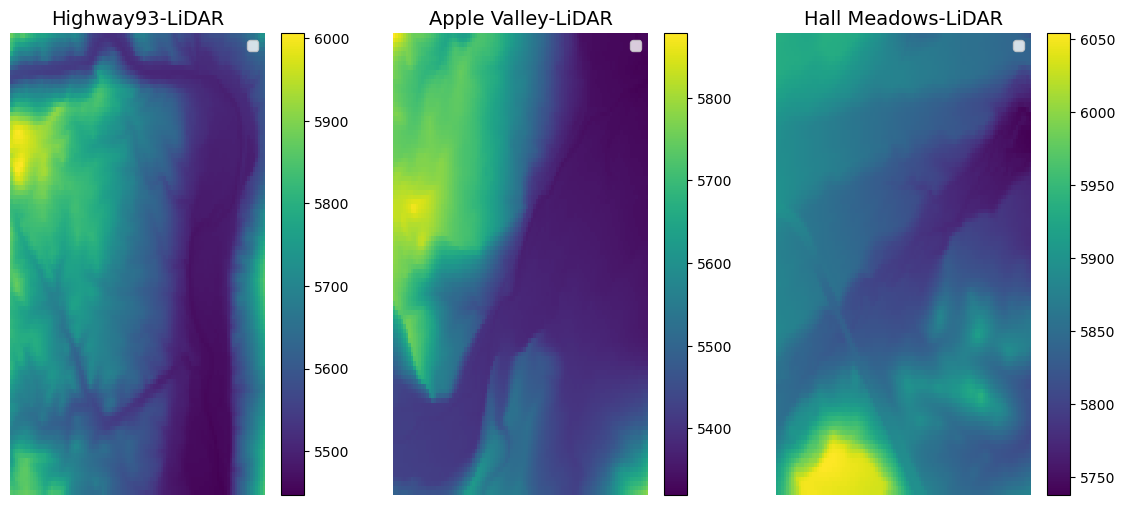

In [12]:
# Call function to plot Lidar DTMs
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
plot_title = ['Highway93-LiDAR', 
              'Apple Valley-LiDAR', 
              'Hall Meadows-LiDAR']
lidar_dtm_list = [applevalley_lidar_dtm, hallmeadows_lidar_dtm, highway93_lidar_dtm]
for i, axe in enumerate(axes.flatten()):
    plot_model(model=lidar_dtm_list[i], 
               title=plot_title[i],
               coarsen=(True),
               xpix=20, 
               ypix=20,
               ax=axe)

In [ ]:
def boundary_gdf(shape_url):
    
    "download boundary shapefiles and open as a gdf"

In [9]:
# Create gdf for shapefiles (for clipping to AOI)
# to do - upload shapefiles for download
shp_path = os.path.join('shapefiles.zip')
with zipfile.ZipFile(shp_path, 'r') as shp_zipfile:
            shp_zipfile.extractall(working_dir)
            #shp_zipfile.printdir()
applevalley_shp_path = (os.path.join('shapefiles', 
                                     'applevalley_bounding_polygon'))
hallmeadows_shp_path = (os.path.join('shapefiles', 
                                     'hallmeadows_bounding_polygon'))
highway93_shp_path = (os.path.join('shapefiles', 
                                     'highway93_bounding_polygon'))
applevalley_clip_gdf = gpd.read_file(applevalley_shp_path)
hallmeadows_clip_gdf = gpd.read_file(hallmeadows_shp_path)
highway93_clip_gdf = gpd.read_file(highway93_shp_path)

In [10]:
# Write function for opening and clipping the geotiff file

def lidar_clip(lidar_dtm, clip_gdf):
    """
  Clips and reprojects the lidar raster to the area of interest (AOI)
  using a supplied shapefile.

  Parameters
  ----------
  lidar_dtm: dataarray
      The dtm to clip.
  clip_gdf: geodatafram
      GDF of the AOI.

  Returns
  -------
  clipped_dtm = DataArray
      The preprocessed raster dataset.
  """
    #data_dir = os.path.join(site_name, '{}_lidar'.format(site_name))
    reproject_dtm = lidar_dtm.rio.reproject("EPSG:4326")
    clipped_dtm = (reproject_dtm
                  .squeeze()
                  .rio.clip(clip_gdf.geometry, crs=clip_gdf.crs))
    # Save the clipped lidar dtm as raster for use in RiverREM
    # Clipped_dtm.rio.to_raster(data_dir, '{}_lidar_dtm_clipped.tif'.format(site_name))
    
    return clipped_dtm

In [11]:
# Reproject and clip the lidar dtms
highway93_clip_dtm = lidar_clip(lidar_dtm = highway93_lidar_dtm, 
                                clip_gdf=highway93_clip_gdf)
applevalley_clip_dtm = lidar_clip(lidar_dtm = applevalley_lidar_dtm, 
                                clip_gdf=applevalley_clip_gdf)
hallmeadows_clip_dtm = lidar_clip(lidar_dtm = hallmeadows_lidar_dtm, 
                                clip_gdf=hallmeadows_clip_gdf)

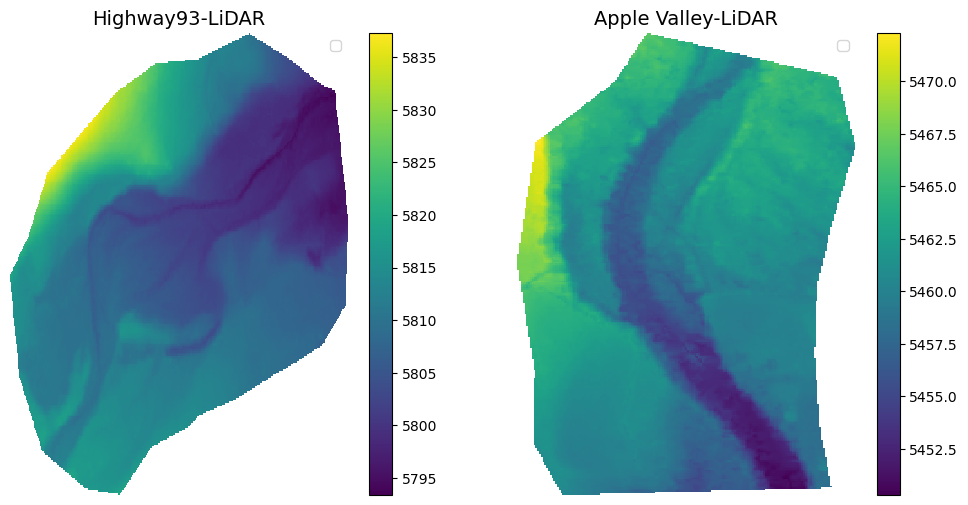

In [15]:
# Call function to plot lidar DTMs
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_title = ['Highway93-LiDAR', 
              'Apple Valley-LiDAR'] 
              #'Hall Meadows-LiDAR']
lidar_clipped_dtm_list = [highway93_clip_dtm, applevalley_clip_dtm] #hallmeadows_clip_dtm]
for i, axe in enumerate(axes.flatten()):
    plot_model(model=lidar_clipped_dtm_list[i], 
               title=plot_title[i],
               coarsen=(False),
               ax=axe)

# Load the UAV DTMs and REMs

In [16]:
# Define urls to UAV DTMs and REMs (saved on zenodo)
# make into function
highway93_dtm_url = ('https://zenodo.org/record/8218054/files/'
                     'highway93_uav_dtm.tif?download=1')
highway93_rem_url = ('https://zenodo.org/record/8218054/files/'
                     'highway93_uav_rem.tif?download=1')
applevalley_dtm_url = ('https://zenodo.org/record/8218054/files/'
                       'applevalley_uav_dtm.tif?download=1')
applevalley_rem_url = ('https://zenodo.org/record/8218054/files/'
                       'applevalley_uav_rem.tif?download=1')
hallmeadows_dtm_url = ('https://zenodo.org/record/8218054/files/'
                       'hallmeadows_uav_dtm.tif?download=1')
hallmeadows_rem_url = ('https://zenodo.org/record/8218054/files/'
                       'hallmeadows_uav_rem.tif?download=1')

In [18]:
# Load dataarrays for UAV-derived dtms and rems and lidar rems
highway93_uav_dtm = load_dtm(data_url = highway93_dtm_url, 
                          site_name = 'highway93',
                          file_name = 'highway93_dtm.tif')
applevalley_uav_dtm = load_dtm(data_url = applevalley_dtm_url, 
                          site_name = 'applevalley',
                          file_name = 'applevalley_dtm.tif')
hallmeadows_uav_dtm = load_dtm(data_url = hallmeadows_dtm_url, 
                          site_name = 'hallmeadows',
                          file_name = 'hallmeadows_dtm.tif')
highway93_uav_rem = load_dtm(data_url = highway93_rem_url, 
                          site_name = 'highway93',
                          file_name = 'highway93_rem.tif')
applevalley_uav_rem = load_dtm(data_url = applevalley_rem_url, 
                          site_name = 'applevalley',
                          file_name = 'applevalley_rem.tif')
hallmeadows_uav_rem = load_dtm(data_url = hallmeadows_rem_url, 
                          site_name = 'hallmeadows',
                          file_name = 'hallmeadows_rem.tif')

## To do for steps above
1) how to write to raster - running into error driver no found
2) speeding up plots/reducing file size?
3) another issue I came across is that for the hallmeadows site, the AOI overlaps 2 tiles - is there a way to combine the 2 lidar rasters into one, then clip to AOI?
4) upload all files including shapefiles to git or zenodo
5) modulariize code/reduce redudancy - look into using locals or dictionaries
6) pickling??

## LiDAR and UAV DTM histograms

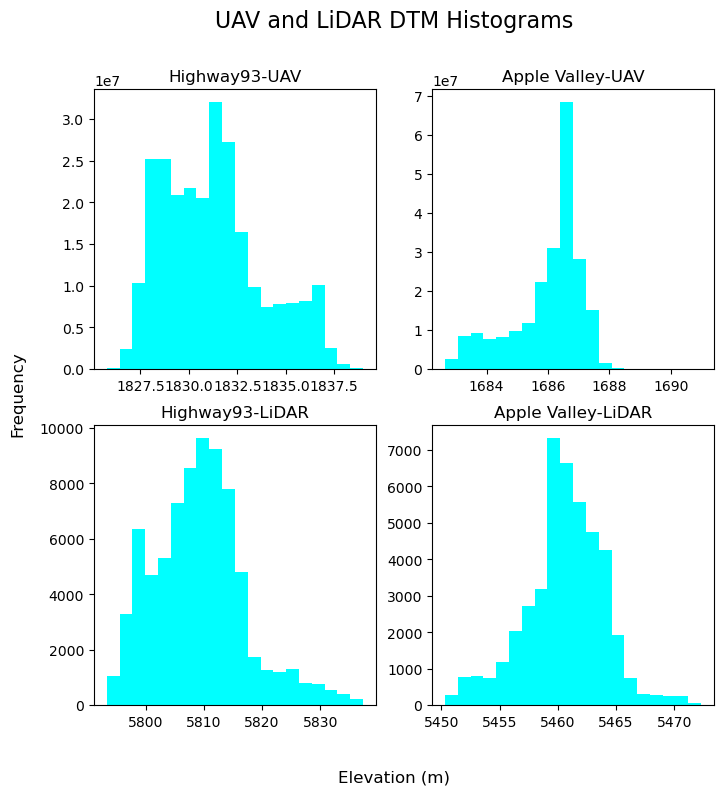

In [19]:
all_dtm_list = (highway93_uav_dtm, applevalley_uav_dtm,
                highway93_clip_dtm, applevalley_clip_dtm)
# Call function to plot histogram of UAV REMs
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
plot_title = ['Highway93-UAV', 
              'Apple Valley-UAV', 
              'Highway93-LiDAR', 
              'Apple Valley-LiDAR']

for i, axe in enumerate(axes.flatten()):
    plot_hists(model=all_dtm_list[i], 
               titles=plot_title[i],
               main_title='UAV and LiDAR DTM Histograms',
               color=('cyan'),
               fig=fig,
               ax=axe)

In [ ]:
# Run the process lidar function to create a lidar-derived DTM for each site
site_names = ('highway93', 'applevalley', 'hallmeadows')

# try using locals
#lidar_dtm_list = []
#for site in site_names:
 #   processed_lidar_dtm = reproject_match_lidar(site_uav_rem, lidar_path, lidar_crs, name)
    #lidar_dtm_list.append(lidar_rem)
    

# Create LiDAR REMs Using REMMaker Tool

In [ ]:
def run_rem_maker(name, k=100):
    """Run the REMMaker tool"""
    
    # Input the DTM file path and desired output directory
    override_cache = False
    lidar_dtm_path = os.path.join(('LiDAR_DTM_{}.tif').format(name))
    lidar_out_path = os.path.join(lidar_dir, ('lidar_{}').format(name))
    lidar_rem_path = os.path.join(lidar_out_path, 
                                  ('LiDAR_DTM_{}_REM.tif').format(name))

    # Run the REMMaker if the path to the REM does not already exist
    if (not os.path.exists(lidar_rem_path)) or override_cache:
        rem_maker = REMMaker(dem=lidar_dtm_path, 
                             out_dir=lidar_out_path, 
                             interp_pts=1000, 
                             k=100)

        # clear OSM cache
        clear_osm_cache()

        # create an REM
        rem_maker.make_rem()

        # create an REM visualization with the given colormap
        rem_maker.make_rem_viz(cmap='mako_r')

    else:
        print('The REM already exists. Not running REMMaker')

In [ ]:
# Create REM for all sites with run_rem_maker function
site_names = ('highway93', 'applevalley', 'hallmeadows')
lidar_rem_list = []

for site in site_names:
    run_rem_maker(name=site)
    lidar_rem_path = os.path.join(lidar_dir,
                                  ('lidar_{}').format(site),
                                  ('LiDAR_DTM_{}_REM.tif').format(site))
    lidar_rem = rxr.open_rasterio(lidar_rem_path, masked=True)    
    lidar_rem_list.append(lidar_rem)

# Plot the UAV and LiDAR Derived REMs

In [ ]:
# Plot the REMs
# Define plot space with x subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 14))

# List of site names to pass to function for titles
plot_title = ('UAV-Derived REM for Highway 93', 
              'UAV-Derived REM for Apple Valley', 
              'UAV-Derived REM for Hall Meadows',
              'LiDAR-Derived REM for Highway 93', 
              'LiDAR-Derived REM for Apple Valley', 
              'LiDAR-Derived REM for Hall Meadows')

# List of REMs to pass to plot function
all_rem_list = (uav_rem_list + lidar_rem_list)

# Call plot function
for i, axe in enumerate(axes.flatten()):
    plot_models(
        model=all_rem_list[i],
        title=plot_title[i],
        coarsen=(True, True, True, False, False, False),
        ax=axe)
# Note - I increased value of k in the REMMAker and streaking improved!!
# "param k: number of nearest neighbors to use for IDW interpolation. If None, an appropriate value is estimated.
#  The estimation routine uses k between 5-100 points (0.5-10% of the river length) depending on the
#  sinuosity of the river of interest. Greater values of k are used for more sinuous rivers.""